# Join plots for models

Join in one graph the plots for all p

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model

In [3]:
def model_function(x: float,a1: float,a2: float,a3: float,a4: float):
    return a1*np.sqrt(-np.log(a2+a3*x+a4*x**2))

def get_extrapol_function(model_function,a1,a2,a3,a4):
    def extrapol_funct(x):
        return model_function(x,a1,a2,a3,a4)
    return extrapol_funct

## Get data

In [4]:
data_path = Path("../../../data/").resolve()
file_all_tc = 'all_inv_Tc.csv'
df_inv_all_tc = pd.read_csv(os.path.join(data_path,file_all_tc))
file_params = "inv_Tc_vs_inv_nv_sqrt_and_log_4_parms_params_curves.csv"
df_params = pd.read_csv(os.path.join(data_path,"Extrapolation",file_params),index_col=0)
file_extrapol_val = "inv_Tc_vs_inv_nv_sqrt_and_log_4_parms_extrapol_values.csv"
df_extrapol_val = pd.read_csv(os.path.join(data_path,"Extrapolation",file_extrapol_val),index_col=0)

In [5]:
df_params

,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
a1,1.282267,1.125149,1.002703,0.828062,0.846626,0.860980,0.867596,0.859030,0.851384,1.261817,1.881553
a2,0.994201,0.985948,0.970093,0.933899,0.908451,0.879229,0.845327,0.802483,0.756088,0.855125,0.918711
a3,-0.334922,-0.499224,-0.678917,-1.030296,-0.983801,-0.927888,-0.873849,-0.825787,-0.759647,-0.347227,-0.138675
a4,-0.242578,-0.165934,-0.052283,0.219005,0.209771,0.192378,0.176495,0.165655,0.140869,-0.102952,-0.114074


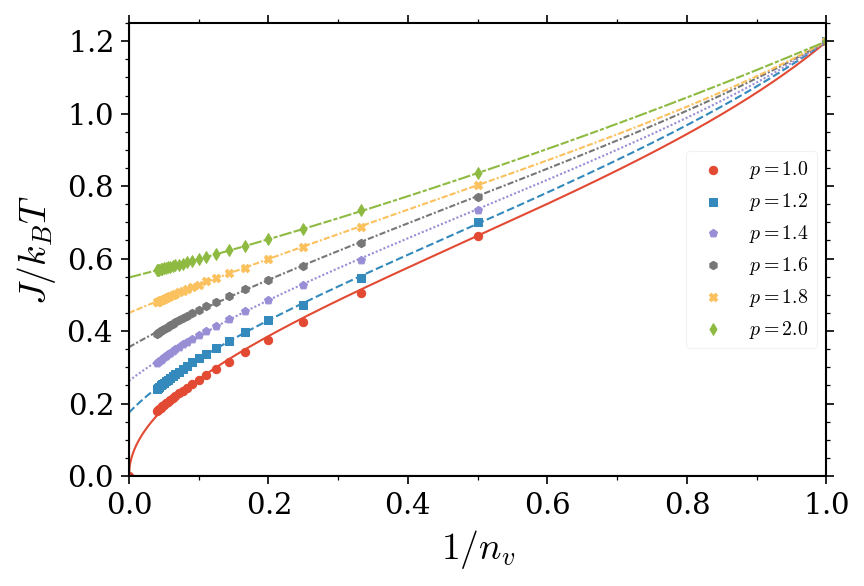

In [16]:
columns = ["P1.0",
#            "P1.1",
           "P1.2",
#            "P1.3",
           "P1.4",
#            "P1.5",
           "P1.6",
#            "P1.7",
           "P1.8",
#            "P1.9",
           "P2.0"]

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False
markers = ["o",
#            "v",
           "s",
#            "P",
           "p",
#            "*",
           "h",
#            "D",
           "X",
#            "8",
           "d"]
line_styles = ["solid",
#                "dotted",
               "dashed",
#                "dashdot",
               (0,(1,1)),
#                (0,(5,1)),
               (0,(3,1,1,1)),
#                (0,(3,1,1,1,1,1)), 
               (0,(3,1,3,1,1,1)),
#                (0,(5,1,3,1,1,1)),
               (0,(6,1,4,1,2,1)),
               (0,(1,10)),
               (0,(5,10)),
               (0,(3,10,1,10))]

fig1: Figure = pyplot.figure(figsize=(6, 4), dpi=150)
grid_spec = GridSpec(1, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

for index,column in enumerate(columns):
    # get p value
    p_val = float(column.replace("P",""))
    # Get inv_tc per col
    y_data_all = df_inv_all_tc.loc[:, column]

    x_data = np.array(df_inv_all_tc.loc[y_data_all.notnull(), "1/nv"])
    y_data = np.array(y_data_all.loc[y_data_all.notnull()])
    
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
    
    if column == 'P1.0':
        # add value at nv=infty
        x_data = np.insert(x_data,0,0)
        y_data = np.insert(y_data,0,0)
        
        a1 = 0.9095358201995817
        a2 = 0.823943352389555
        
#         a1= 0.7655296081946619
#         a2= 1.0000999999999998
#         a3= -1.176310678075717
#         a4= 0.26212475901754795
        
        x_data_fine = np.linspace(0, 1, num=1024)
        y_extrapol = a1*np.sqrt(-np.log(1-a2*x_data_fine))
#         y_extrapol = a1*np.sqrt(-np.log(a2+a3*x_data_fine+a4*x_data_fine**2))
        
        ax.plot(x_data_fine, y_extrapol, lw=1,linestyle=line_styles[index], color='C'+str(index))
        ax.scatter(x_data, y_data, marker=markers[index], color='C'+str(index),label = '$p=1.0$')

    else:
        # get params
        (a1,a2,a3,a4) = df_params[column].values

        # get model
        extrapol_funct = get_extrapol_function(model_function, a1, a2, a3, a4)    

        # plot
        x_data_fine = np.linspace(0, 1, num=1024)
        y_data_fine = extrapol_funct(x_data_fine)
        ax.plot(x_data_fine, y_data_fine, lw=1,linestyle=line_styles[index], color='C'+str(index))

        ax.scatter(x_data, y_data, marker=markers[index], color='C'+str(index),label = '$p={}$'.format(p_val))
        
# ticks configuration
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$1 / n_v$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$J / k_B T$")

ax.set_ylim(0, 1.25)
ax.set_xlim(0, 1)
# ax.set_ylim(0, 0.5)
# ax.set_xlim(0, 0.2)

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.legend(
          loc ="center right",
          fontsize = 9.5
        )
# ax.axvline(x=0,linestyle="-",color="black")
# ax.axhline(y=0,linestyle="-",color="black")

# ax.set_xscale("log")
# ax.set_yscale("log")

pyplot.draw()
pyplot.show()

In [17]:
df_extrapol_val

,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
infty,0.097790,0.133850,0.174723,0.216545,0.262336,0.308887,0.355642,0.402962,0.450186,0.499188,0.547862
1,1.199717,1.199733,1.199789,1.199621,1.199336,1.199175,1.199270,1.199403,1.199670,1.199723,1.199661


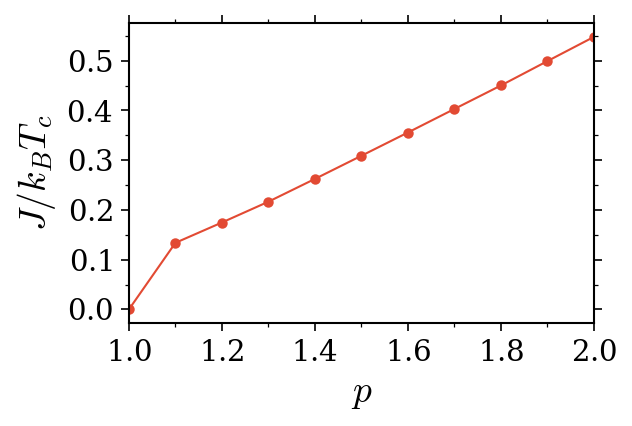

In [24]:
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_sqrt_and_log_3_parms'
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# take zero
df_extrapol_val.loc['infty']["P1.0"]=0
# data 
x_data = np.arange(1,2.1,0.1)
y_data = df_extrapol_val.loc['infty'].values

# x_data = np.delete(x_data,0)
# y_data = np.delete(y_data, 0)
# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

# ticks configuration
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$p$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$J/k_BT_c$")
# ax.axvline(x=1,linestyle='--')

# ax.set_ylim(1.5,8)
ax.set_xlim(1, 2)


pyplot.draw()

# print('Save graph {}'.format(file_extrapol_graph))
# pyplot.savefig(file_extrapol_graph)

pyplot.show()